In [12]:
from time import perf_counter_ns

from numpy import *

from calc_catenary_from_ext_points import *

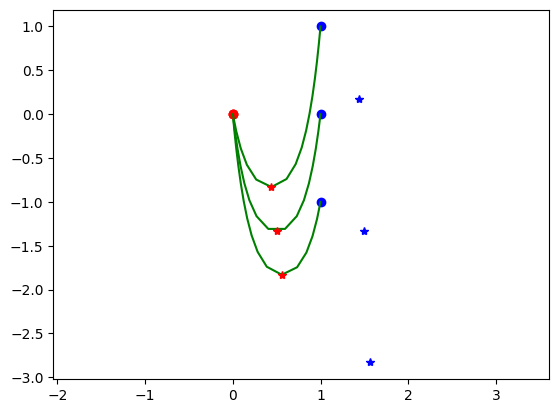

In [13]:
A = [ 0, 0, 0 ]
B = [ 1, 0, 1 ]

for d in linspace( -1, 1, 3 ):
	B[ 2 ] = d
	P, _, D, H = get_coor_marker_points_ideal_catenary( *A, *B, 3, .2 )
	plt.plot( *(A[ ::2 ]), 'ro' )
	plt.plot( *(B[ ::2 ]), 'bo' )
	plt.plot( P[ :, 0 ], P[ :, 2 ], 'g-' )

	L0 = [ A[ 0 ] + D, A[ 2 ] - H ]
	L1 = [ B[ 0 ] + D, B[ 2 ] - H ]
	plt.plot( *L0, 'r*' )
	plt.plot( *L1, 'b*' )
plt.axis( 'equal' )
plt.show()

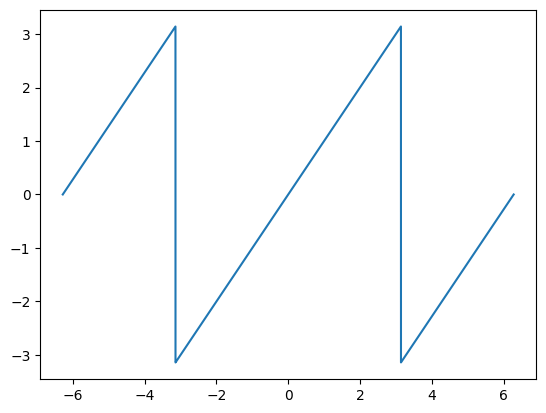

In [14]:
plt.figure()
X = [ v for v in linspace( -2 * pi, 2 * pi, 10000 ) ]
Y = [ (v + pi) % (2 * pi) - pi for v in X ]
plt.plot( X, Y )
plt.show()

In [44]:
mat_sizes = concat(
		(
				linspace( 1, 9, 9 ).astype( int ),
				linspace( 10, 90, 9 ).astype( int ),
				linspace( 100, 1000, 10 ).astype( int )
				)
		)

stack_means = [ ]
for_means = [ ]
for size in mat_sizes:
	v = random.random( (size, 1, 18) )
	M = random.random( (size, 18, 18) )

	stack_times = [ ]
	for_times = [ ]

	for i in range( 10000 ):
		cost0: float = 0.
		t0 = perf_counter_ns()

		cost0 += (v @ M @ v.transpose( (0, 2, 1) )).sum()

		stack_times.append( perf_counter_ns() - t0 )

		cost1: float = 0.

		t0 = perf_counter_ns()

		for j in range( v.shape[ 0 ] ):
			cost1 += v[ j ] @ M[ j ] @ v[ j ].T

		for_times.append( perf_counter_ns() - t0 )

		if cost0 - cost1 > 1e-6:
			print( f"Error: {cost0} != {cost1}" )

	stack_means.append( mean( stack_times ) )
	for_means.append( mean( for_times ) )
	print( f"Stack time: {stack_means[ -1 ] / 1e6}ms" )
	print( f"For time: {for_means[ -1 ] / 1e6}ms" )
	print( f"For {size=} Stack is {for_means[ -1 ] / stack_means[ -1 ]} times faster" )

Stack time: 0.0036312ms
For time: 0.00312848ms
For size=np.int64(1) Stack is 0.8615554086803261 times faster
Stack time: 0.0035567600000000004ms
For time: 0.0061906800000000005ms
For size=np.int64(2) Stack is 1.7405391423655237 times faster
Stack time: 0.00449891ms
For time: 0.01107475ms
For size=np.int64(3) Stack is 2.461651822330298 times faster
Stack time: 0.004425640000000001ms
For time: 0.014125299999999999ms
For size=np.int64(4) Stack is 3.191696568179969 times faster
Stack time: 0.0042130200000000005ms
For time: 0.01635464ms
For size=np.int64(5) Stack is 3.881927928184532 times faster
Stack time: 0.0050375ms
For time: 0.02181372ms
For size=np.int64(6) Stack is 4.330266997518611 times faster
Stack time: 0.005273399999999999ms
For time: 0.02648743ms
For size=np.int64(7) Stack is 5.02283725869458 times faster
Stack time: 0.005919300000000001ms
For time: 0.03281391ms
For size=np.int64(8) Stack is 5.5435456895241 times faster
Stack time: 0.00522927ms
For time: 0.03149584ms
For size=n

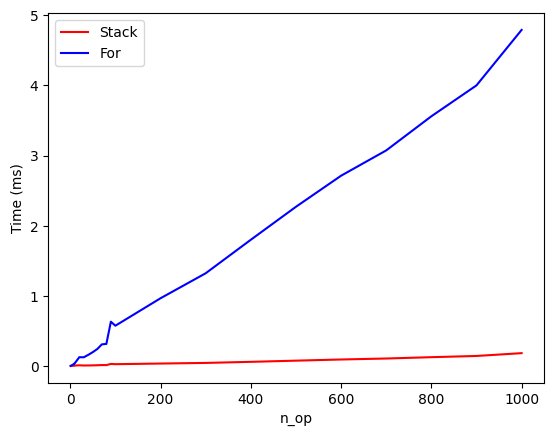

In [45]:
plt.plot( mat_sizes, [ v / 1e6 for v in stack_means ], 'r-' )
plt.plot( mat_sizes, [ v / 1e6 for v in for_means ], 'b-' )
plt.xlabel( 'n_op' )
plt.ylabel( 'Time (ms)' )
plt.legend( [ 'Stack', 'For' ] )
plt.show()

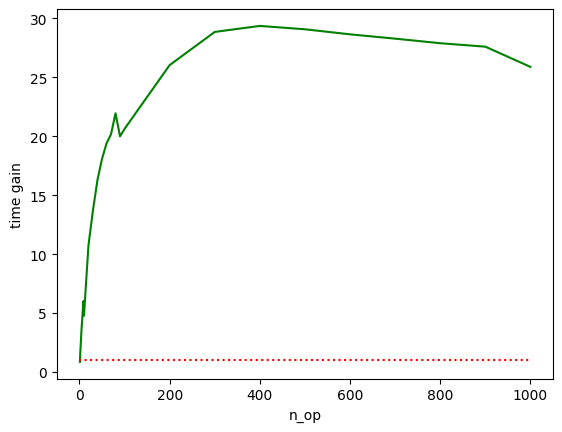

In [46]:
plt.plot( mat_sizes, [ f / s for s, f in zip( stack_means, for_means ) ], 'g-' )
plt.hlines( 1, 0, 1000, 'r', ':' )
plt.xlabel( 'n_op' )
plt.ylabel( 'time gain' )
plt.show()